# KLIMT tutorial
This step-by-step tutorial presents the main functionalities of KLIMT. <br>

#### Notations :
$n$ : number of training samples <br>
$k$ : number of neighbors <br>
$\gamma$ : parameter of the simiarity kernel <br>

In [1]:
from klimt import KLIMT
from utils import print_pred_results
from linear_classifier import nearest_target
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import style
#
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
X_1, y_1 = make_moons(n_samples=4000, noise=0.3, random_state=40)
X_2, y_2 = make_moons(n_samples=4000, noise=0.1, random_state=40)
#
y_2 += 2
X_2[:,:] += -1
#
X = np.concatenate([X_1, X_2])
y = np.concatenate([y_1, y_2])

In [3]:
# For binary clf
# X, y = make_moons(n_samples=4000, noise=0.15, random_state=40)

In [4]:
plt.style.use('seaborn')

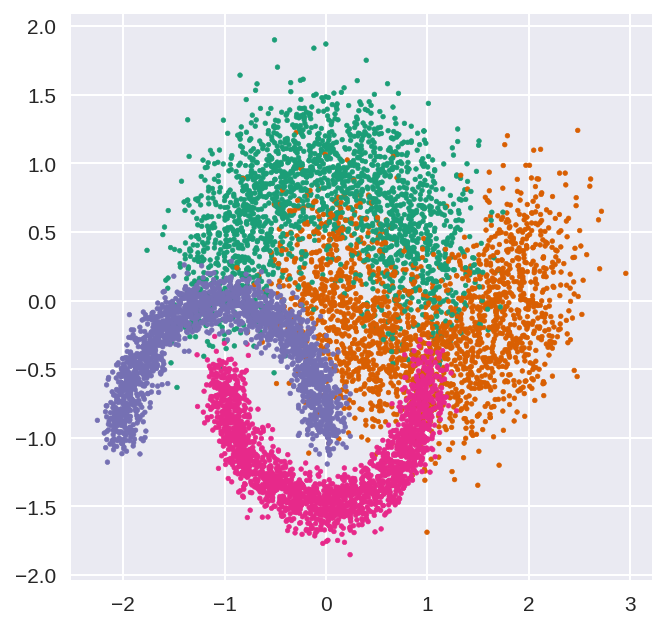

In [5]:
plt.figure(dpi=150, figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=5, c=cm.Dark2(y))

### Split data-set and scale it (such that $d_{max} = 1$)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42, shuffle=True)
# Scaler:
scaler = MinMaxScaler(feature_range=(0, 1/np.sqrt(X_train.shape[1])))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KLIMT model

In [7]:
klimt_model = KLIMT(gamma=10,          # Main parameter
                   k_nn=200,           # param to use only k-nn
                   class_weight=None,  # allow to counter-balance inbalanced classes
                   raise_warning=True, # to show/hide warnings
                   verbose=1,)         # to show/hide infos

In [13]:
# fit and transform training data.
X_train_tr = klimt_model.fit_transform(X_train, y_train)
# Note transforming traning data is not necessary
# klimt_model.fit(X_train, y_train)

Using class barycenter as targets
[KLIMT] Using gamma = 10
[KLIMT] Searching for neighbors with sklearn ...


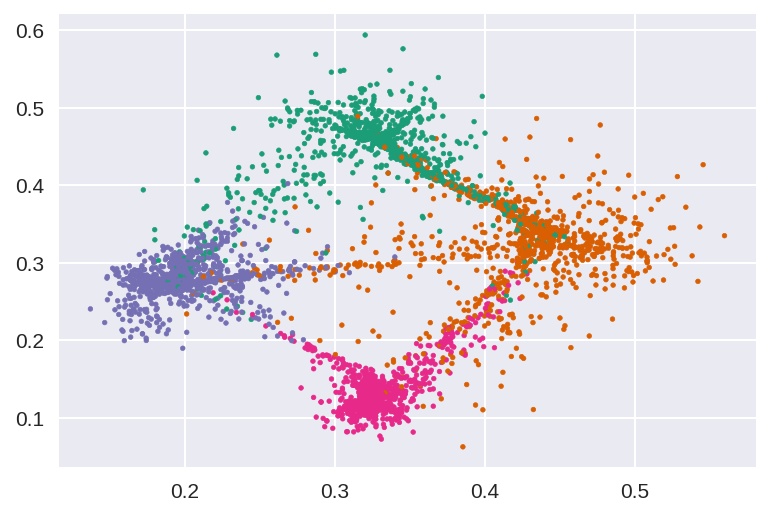

In [14]:
# Train samples
plt.figure(dpi=150)
plt.scatter(X_train_tr[:,0], X_train_tr[:,1], s=5, c=cm.Dark2(y_train))

In [15]:
# transform new samples
X_test_tr = klimt_model.transform(X_test)

[KLIMT] Using gamma = 10
[KLIMT] Searching for neighbors with sklearn ...


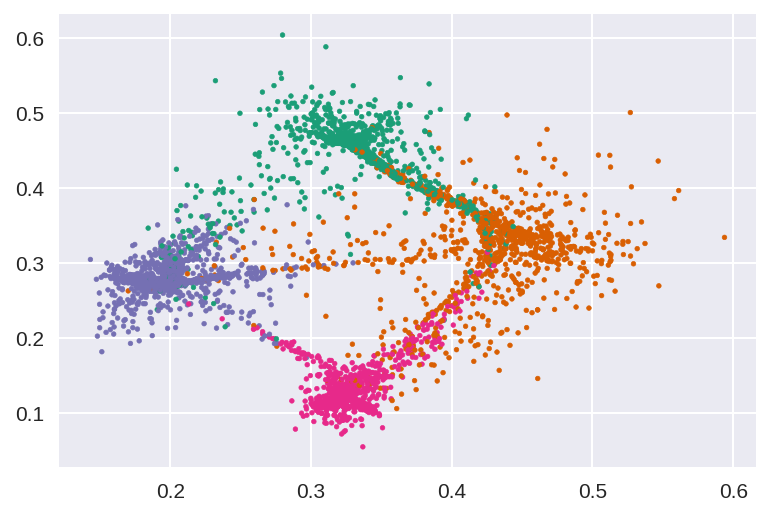

In [16]:
# Test samples
plt.figure(dpi=150)
plt.scatter(X_test_tr[:,0], X_test_tr[:,1], c=cm.Dark2(y_test), s=5)

### Classification

In [17]:
clf = nearest_target(targets=klimt_model.targets)
# ordered_targets return the targets coordinates on the right order
clf.fit(X_train_tr, y_train) # lazy
pred = clf.predict(X_test_tr)
print_pred_results(y_test, pred)

Accuracy : 88.6
Balanced Accuracy : 88.64
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       990
           1       0.87      0.76      0.81      1014
           2       0.88      0.99      0.93       992
           3       0.91      0.96      0.94      1004

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.88      4000
weighted avg       0.89      0.89      0.88      4000



## Now try varying scaling parameter $\gamma$
For a new parameter $\gamma$ the $n \times k$ (pre-computed) distances are re-used.<br>
This allow to speed-up the computation for other parameter $\gamma$.

In [18]:
X_test_tr_2 = klimt_model.transform(X_test, gamma=1e4)

[KLIMT] Using gamma = 10000.0
[KLIMT] Using pre-computed neighbors distances


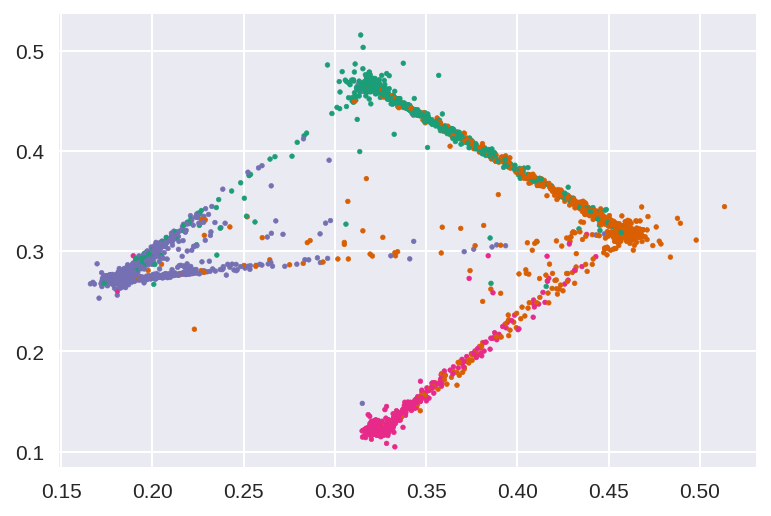

In [19]:
plt.figure(dpi=150)
plt.scatter(X_test_tr_2[:,0], X_test_tr_2[:,1], c=cm.Dark2(y_test), s=5)
# Note the transformed samples seems more shrunk than before

### Classification

In [20]:
# clf = nearest_target(targets=klimt_model.targets)
# # ordered_targets return the targets coordinates on the right order
# clf.fit(X_train_tr, y_train) # lazy
pred = clf.predict(X_test_tr_2)
print_pred_results(y_test, pred)

Accuracy : 89.9
Balanced Accuracy : 89.92
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       990
           1       0.86      0.81      0.84      1014
           2       0.90      0.98      0.94       992
           3       0.94      0.97      0.96      1004

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



## Search for optimal $\gamma$ by Leave One Out Cross Validation
The implementation allows to compute <strong> fast Leave One Out Cross Validation </strong> scores. 

In [21]:
klimt_model = KLIMT(gamma=10,
                   k_nn=500,
                   class_weight=None,
                   raise_warning=True,
                   verbose=0,
                   ).fit(X_train, y_train)

In [22]:
gamma_range = np.logspace(1,5,5)
acc = []
# balanced_acc = []
clf_not_declared = True
for gamma in gamma_range:
    # Keyword loocv=True => Leave-One-Out CV 
    X_train_tr = klimt_model.transform(X=X_train, loocv=True, gamma=gamma)
    if clf_not_declared:
        clf = nearest_target(targets=klimt_model.targets)
    clf.fit(X_train_tr, y_train)
    pred = clf.predict(X_train_tr)
    acc.append(accuracy_score(y_train, pred))
#     balanced_acc.append(balanced_accuracy_score(y_train, pred))

Text(0.5, 1.0, 'Leave-One-Out CV ACC score')

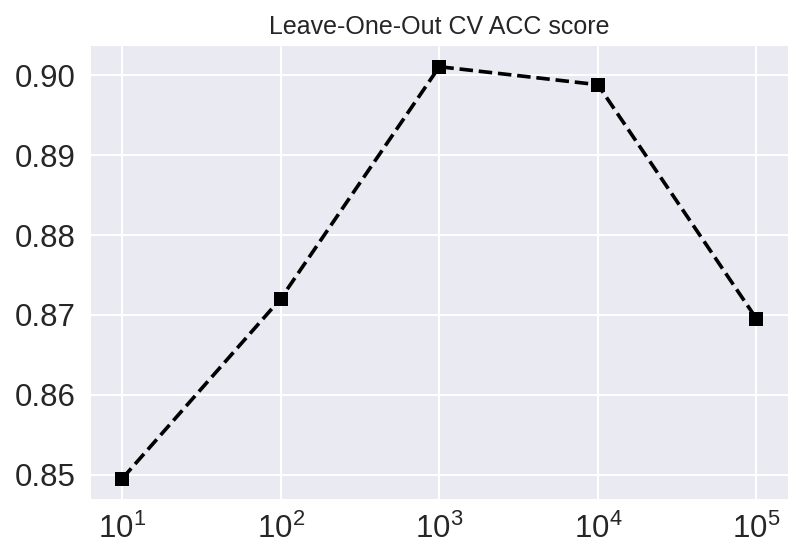

In [23]:
plt.figure(dpi=150)
plt.plot(gamma_range, acc, ls='--', c='k', marker='s')
# plt.plot(gamma_range, balanced_acc, c='k')
plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Leave-One-Out CV ACC score")
# Note : acc and balanced_acc are identical here because of the (perfect) class balanced

In [24]:
# Select the optimal parameter gamma_opt
gamma_opt = gamma_range[np.argmax(acc)]
print(f"The optimal gamma parameter is {gamma_opt}")

The optimal gamma parameter is 1000.0


In [25]:
# transform new samples with gamma_opt
X_test_tr = klimt_model.transform(X_test, gamma=gamma_opt)

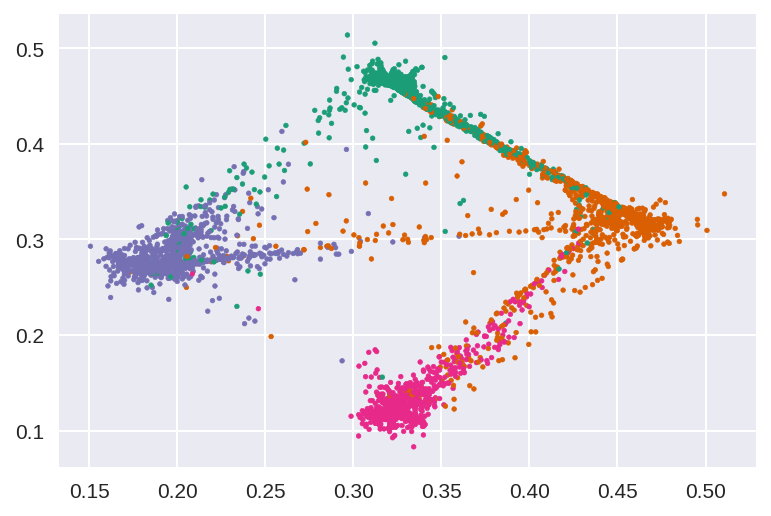

In [26]:
# plot transformed samples
plt.figure(dpi=150)
plt.scatter(X_test_tr[:,0], X_test_tr[:,1], c=cm.Dark2(y_test), s=5)

### Classification

In [28]:
# clf = nearest_target(targets=klimt_model.targets)
# ordered_targets return the targets coordinates on the right order
clf.fit(X_train_tr, y_train) # lazy
pred = clf.predict(X_test_tr)
print_pred_results(y_test, pred)

Accuracy : 89.88
Balanced Accuracy : 89.91
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       990
           1       0.88      0.79      0.83      1014
           2       0.89      0.99      0.94       992
           3       0.94      0.97      0.95      1004

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



### Plot the classification result for a regular grid to visualize the classification frontier

In [23]:
n = 300
x = np.linspace(-0.05,0.75, n)
xx,yy = np.meshgrid(x, x)
coord = np.rollaxis(np.array((xx, yy)).reshape(2,n*n), axis=1)
coord_tr = klimt_model.transform(coord, gamma=gamma_opt)

[]

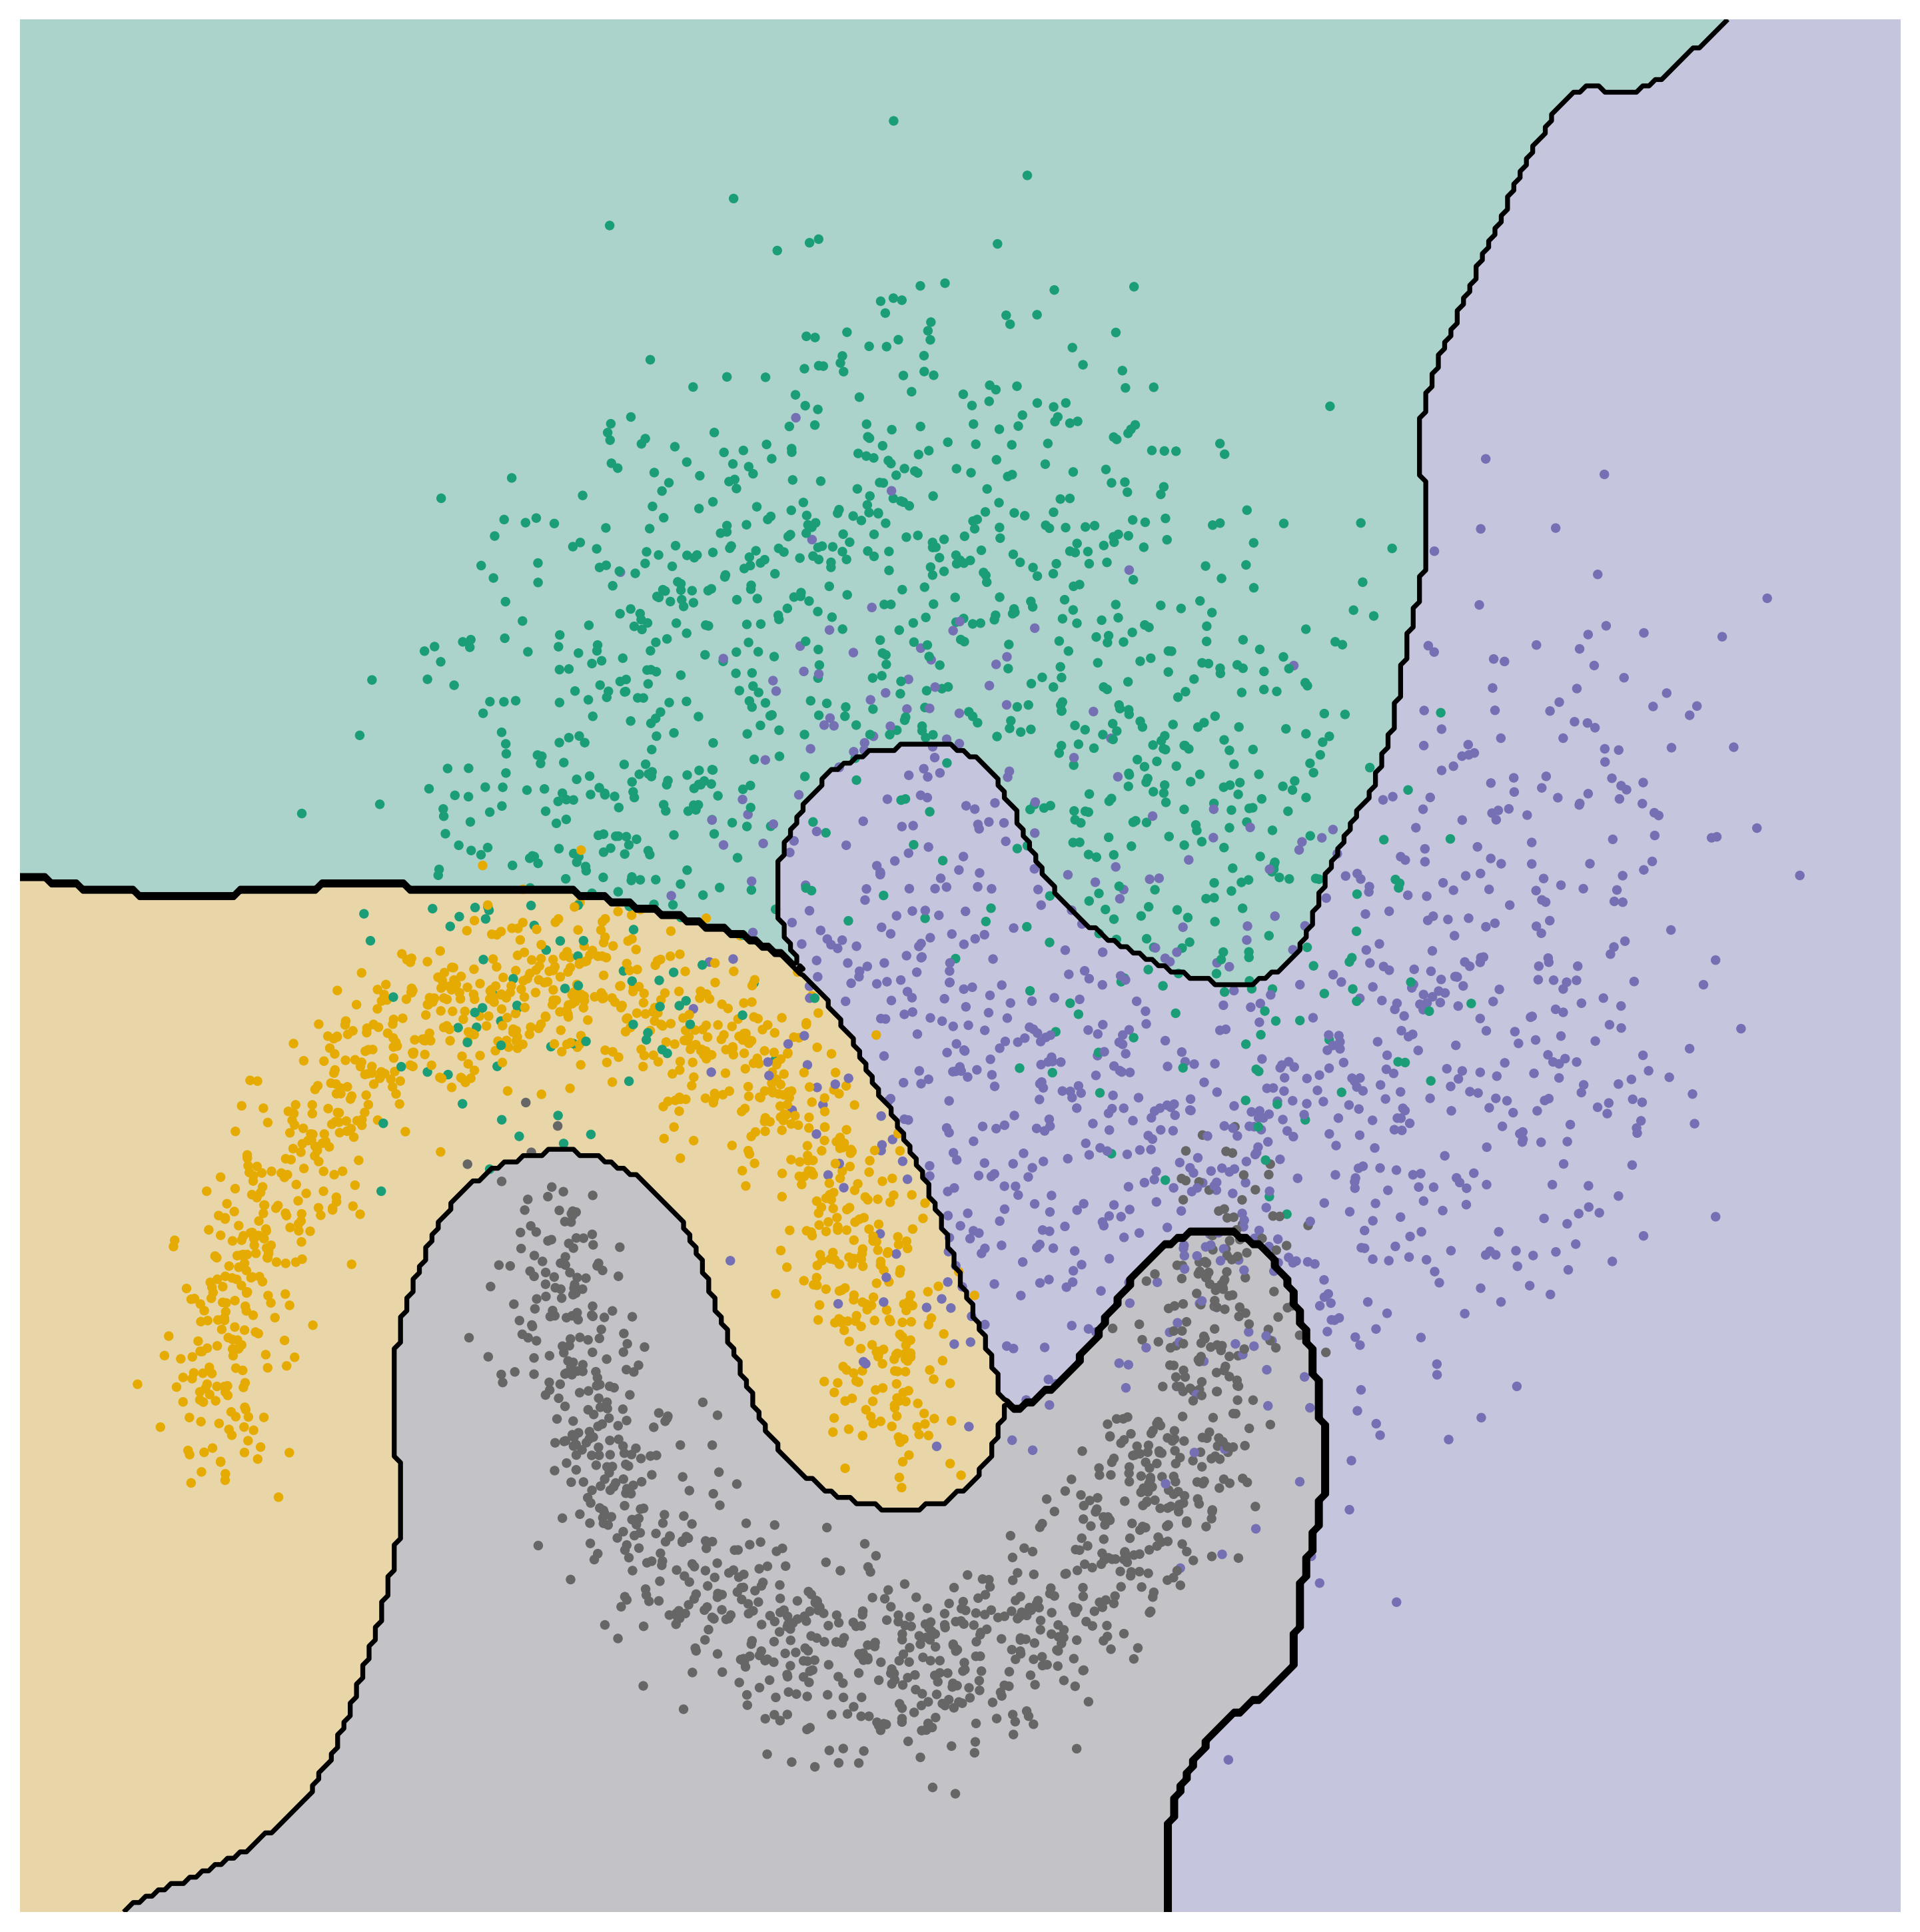

In [24]:
clf = nearest_target(targets=klimt_model.ordered_targets)
clf.compute_distances_to_targets(coord_tr)
pred_coord = clf.predict(coord_tr).reshape(xx.shape)
#
plt.figure(dpi=300, figsize=(10,10))
ax = plt.subplot(111)
ax.contourf(xx, yy, pred_coord, levels=4, cmap='Dark2', alpha=0.3, origin='lower')
ax.contour(xx, yy, pred_coord, levels=[0.5, 1.5, 2.5], origin='lower', colors='k')
ax.scatter(X_train[:,0], X_train[:,1],c=y_train, cmap='Dark2', s=10)
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])

# Visualize 

### Visualize the norm of the transformation

In [25]:
n = 300
x = np.linspace(-0.05,0.75, n)
xx,yy = np.meshgrid(x, x)
coord = np.rollaxis(np.array((xx, yy)).reshape(2,n*n), axis=1)
coord_tr = klimt_model.transform(coord, gamma=gamma_opt)

In [26]:
clf = nearest_target(targets=klimt_model.ordered_targets)
clf.compute_distances_to_targets(coord_tr)
t_max = np.max([np.sum(np.square(coord - klimt_model.ordered_targets[i]), axis=1).max() for i in range(klimt_model.n_classes_)])
t_max = np.sqrt(t_max)

[]

/usr/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


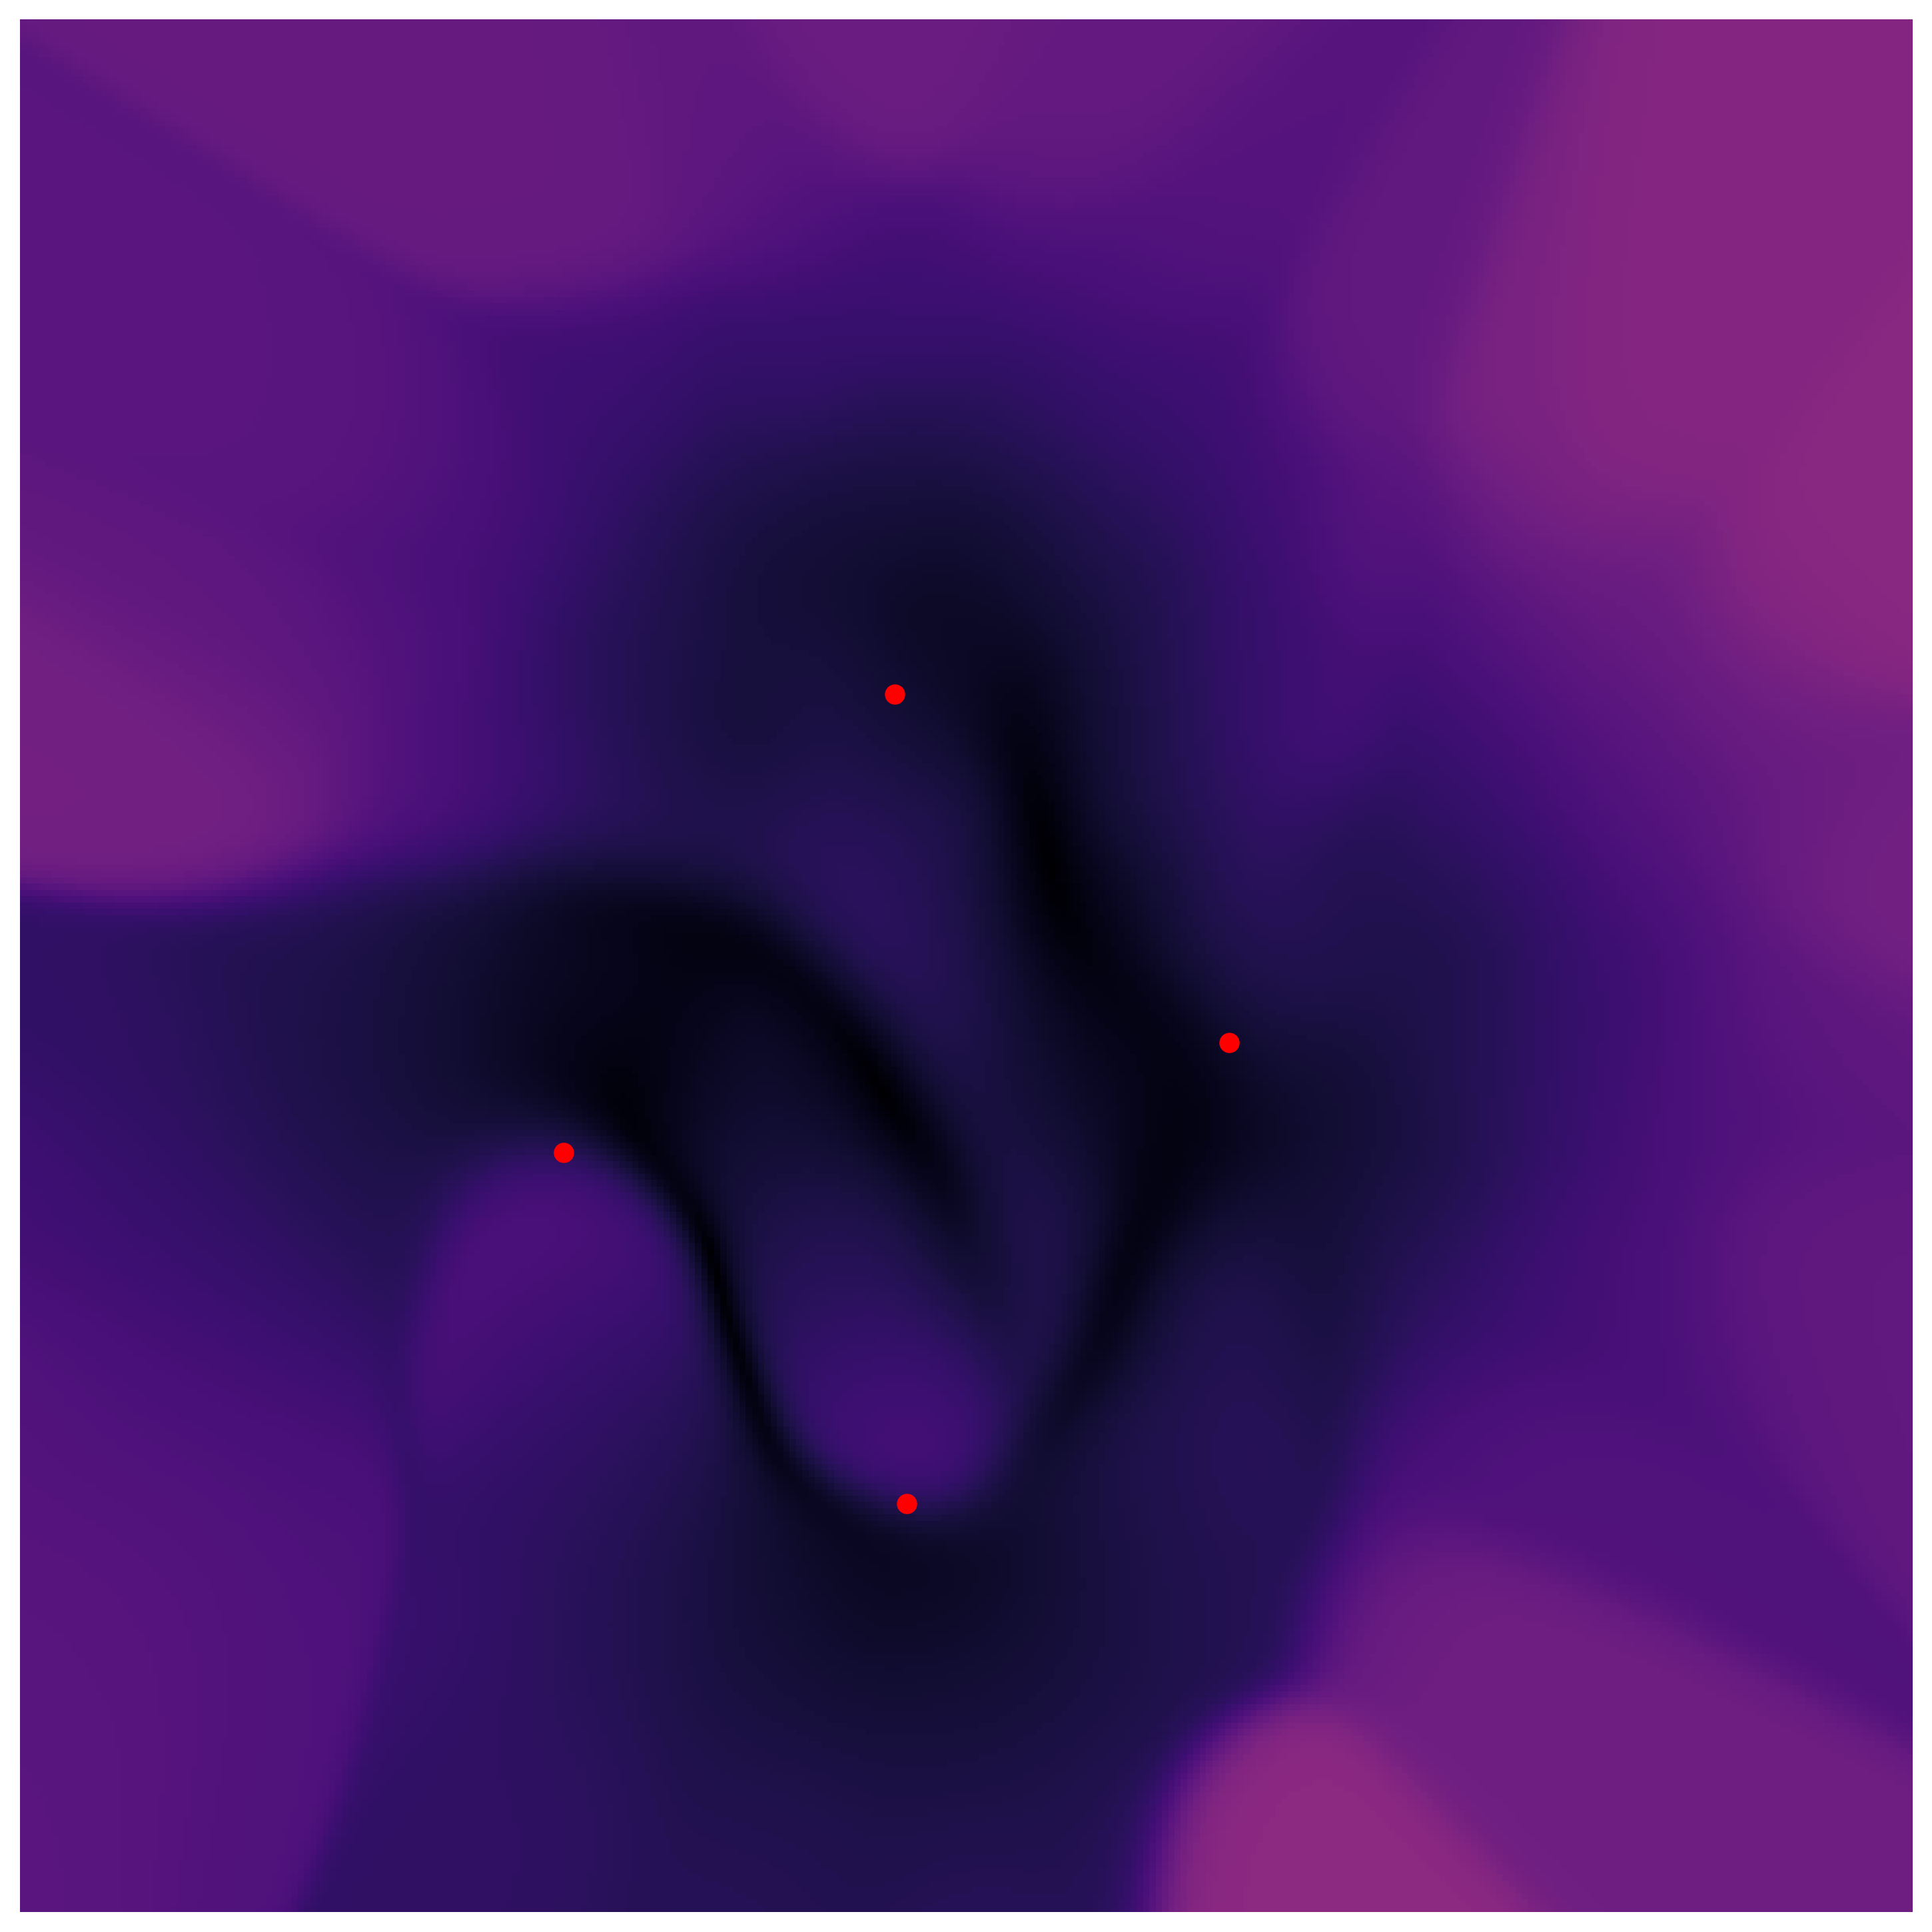

In [71]:
transformation_norm = np.sqrt(np.square(coord_tr - coord).sum(axis=1)).reshape(xx.shape) / t_max
plt.figure(dpi=300, figsize=(10,10))
ax = plt.subplot(111)
cax = ax.imshow(transformation_norm, vmin=0, vmax=1, cmap='magma', extent=[-0.05,0.75,-0.05,0.75], origin='lower')
plt.scatter(klimt_model.ordered_targets[:,0], klimt_model.ordered_targets[:,1], c='r')
# plt.scatter(X[:,0], X[:,1],c=y, cmap='Dark2', s=5, alpha=0.5)
# plt.colorbar(cax)
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])

### Visualize the transformation (vector field) with colors (direction) and saturation (norm)

In [72]:
from flow_vis import flow_to_color

In [73]:
translations = coord - coord_tr
im = translations.reshape(300, 300, 2)
im = np.roll(im, 1, axis=2)
im[:, :, 1] *= -1
#
flow_im = flow_to_color(im)

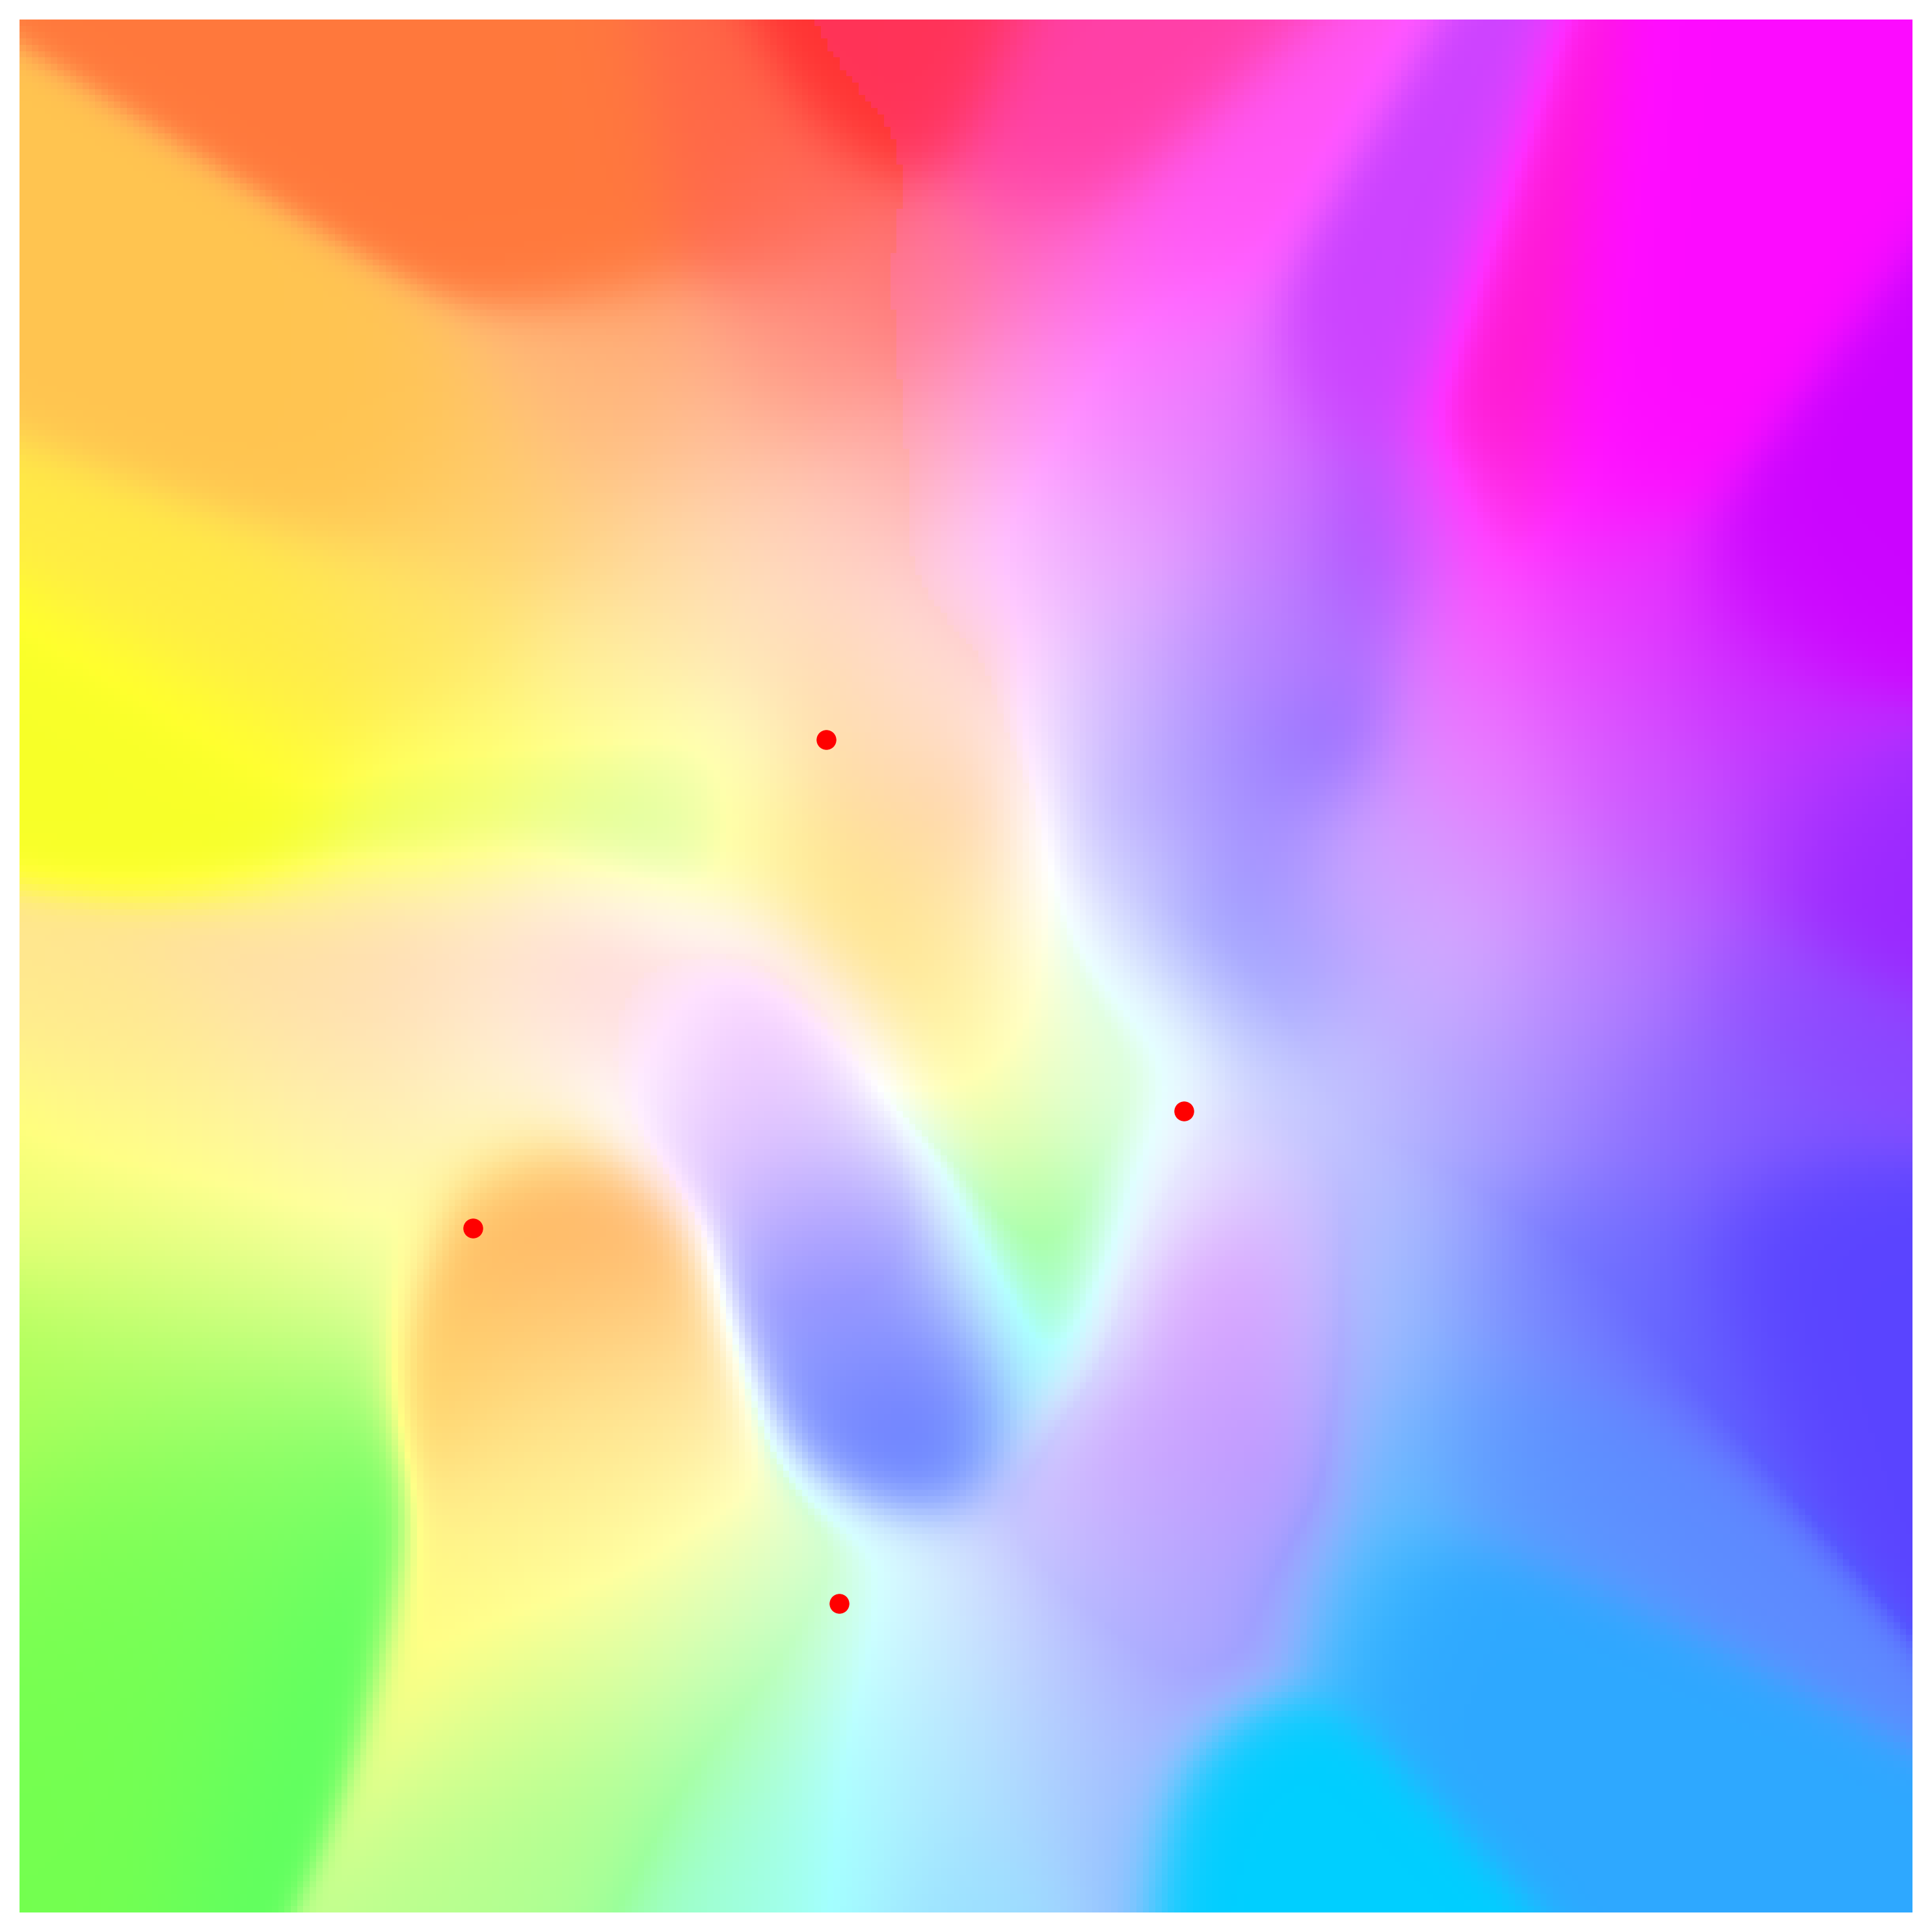

In [74]:
plt.figure(dpi=300, figsize=(10,10))
ax = plt.subplot(111)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(flow_im, origin='lower', extent=[0,0.75,0,0.75])
plt.scatter(klimt_model.ordered_targets[:,0], klimt_model.ordered_targets[:,1], c='r')
plt.tight_layout()

## Reference

In [75]:
n = 300
x = np.linspace(-5,5, n)
xx,yy = np.meshgrid(x, x)
coord = np.rollaxis(np.array((xx, yy)).reshape(2,n*n), axis=1)

In [76]:
translations = coord - np.zeros_like(coord_tr)
im = translations.reshape(300, 300, 2)
im = np.roll(im, 1, axis=2)
im[:, :, 1] *= -1
#
res = flow_to_color(im)

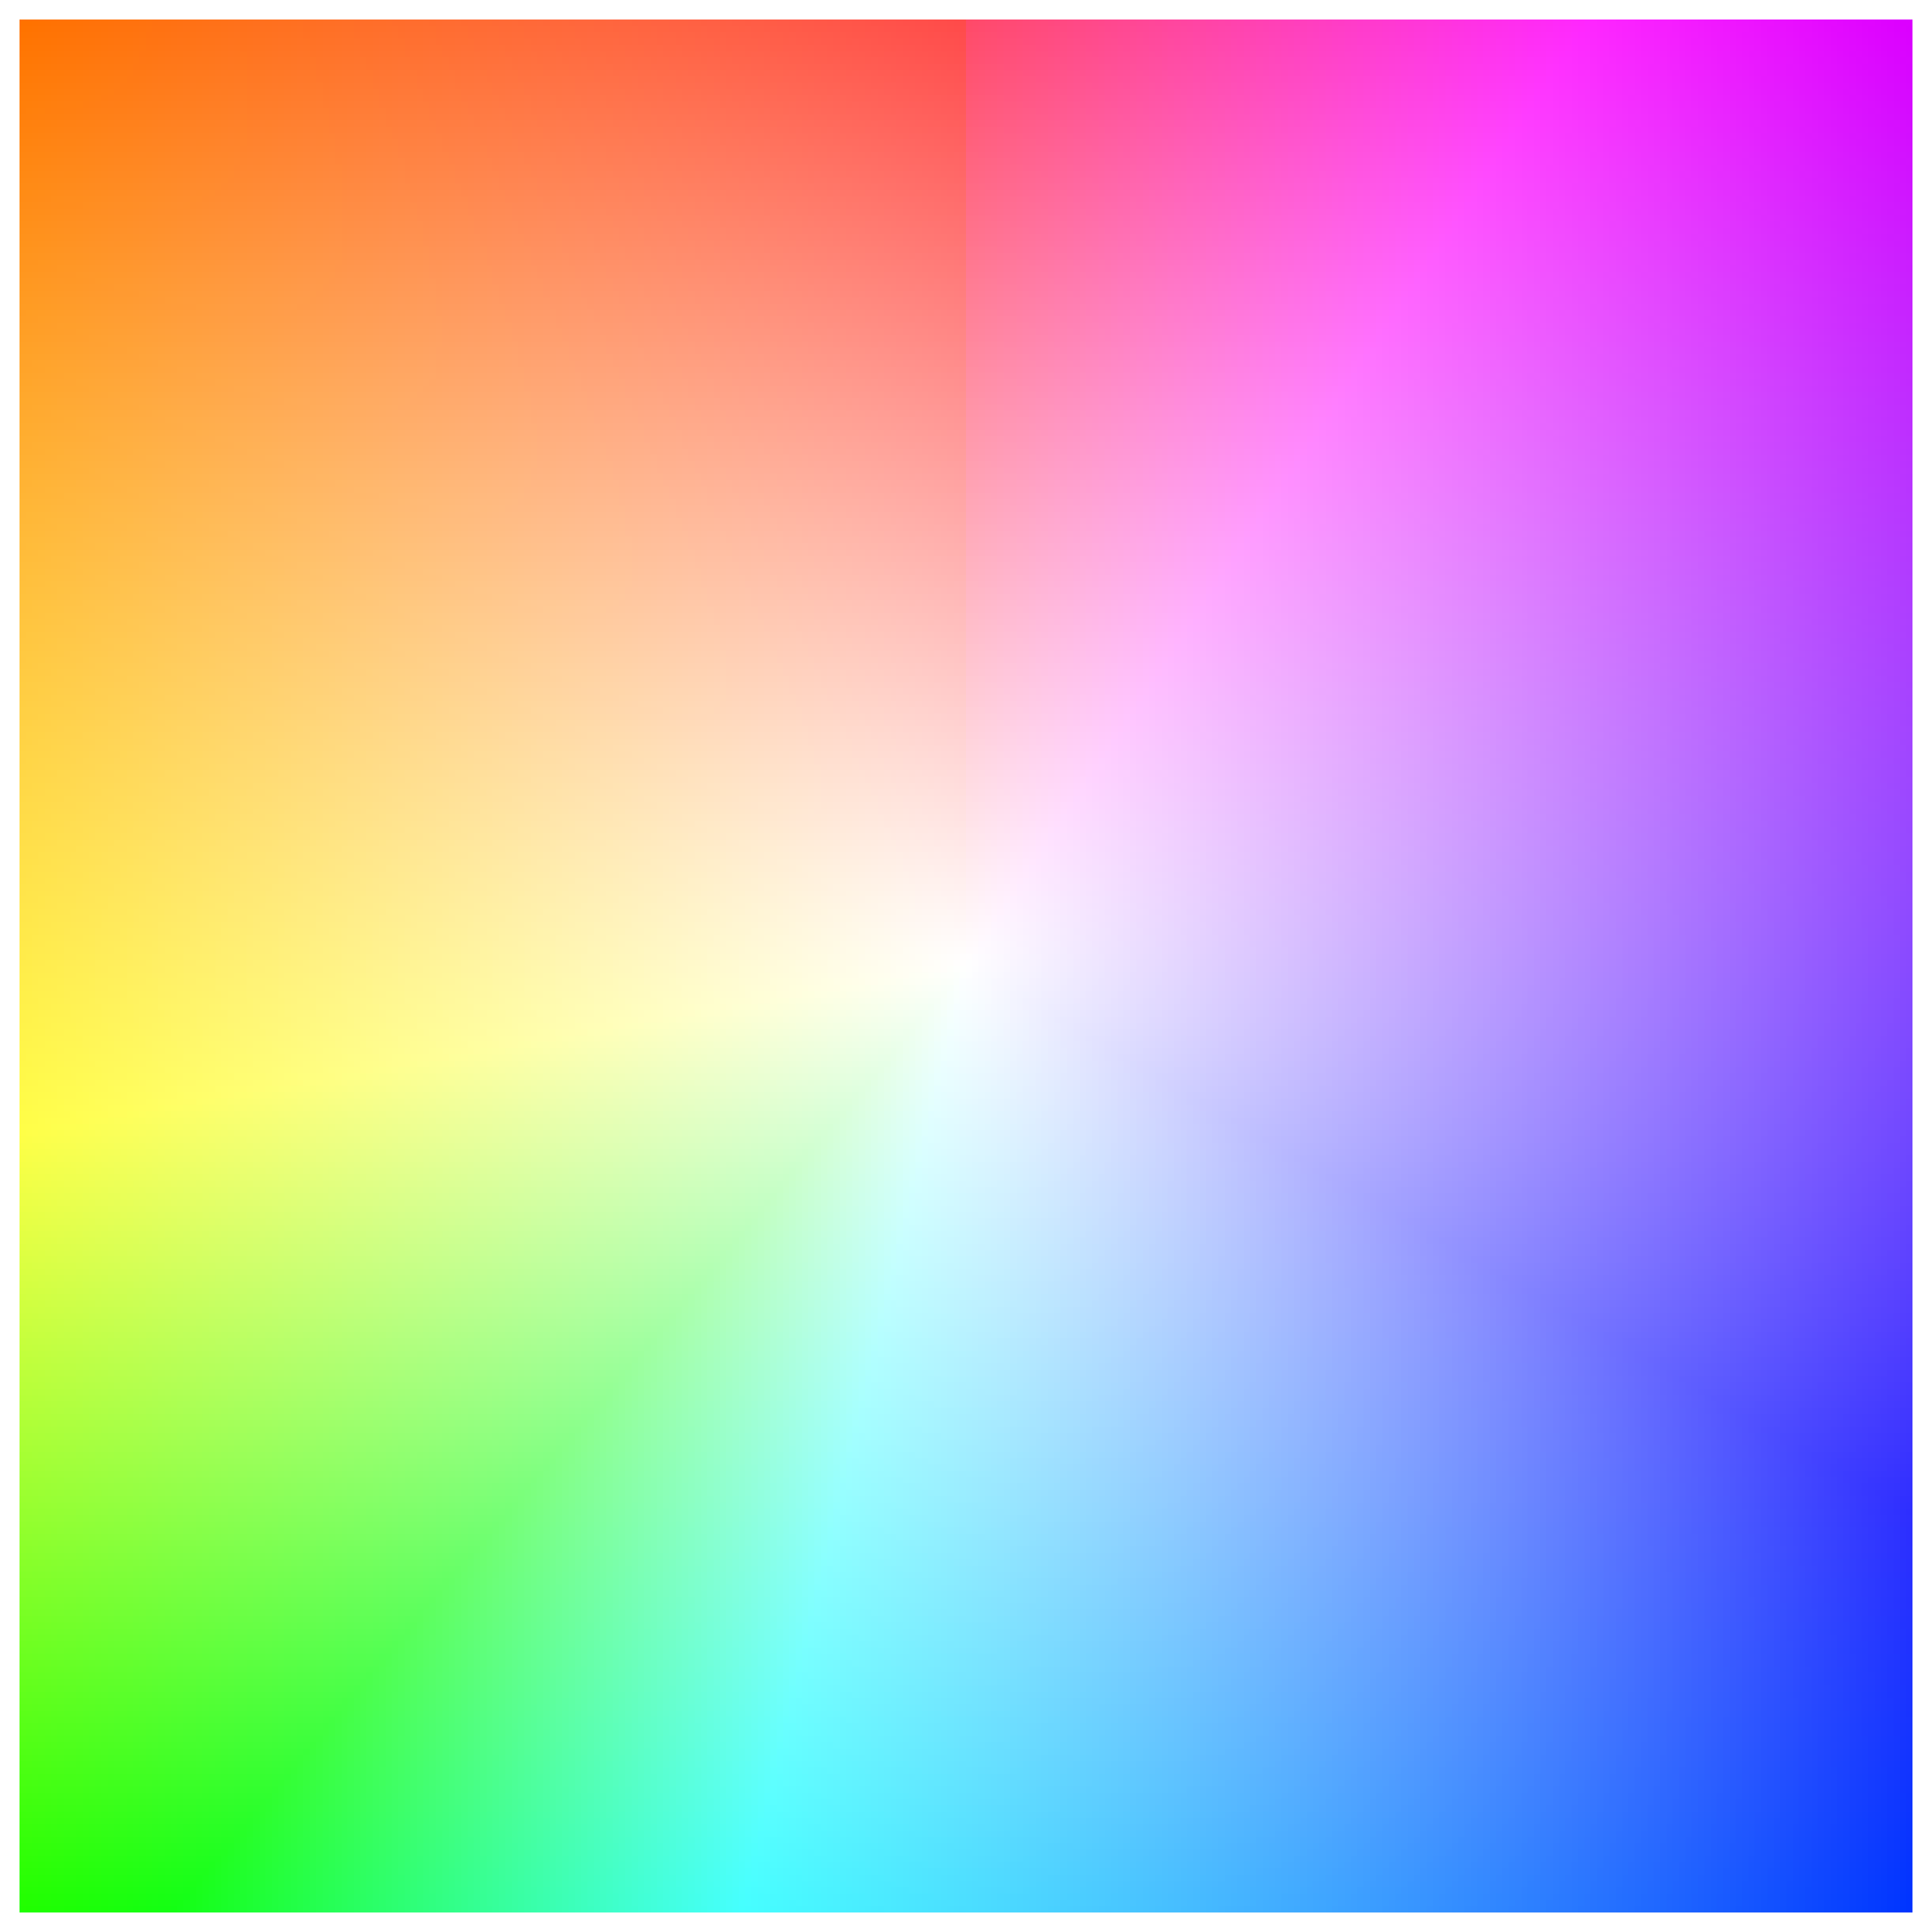

In [77]:
plt.figure(dpi=300, figsize=(10,10))
ax = plt.subplot(111)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(res, origin='lower',)
plt.tight_layout()

# GIF visualization

In [27]:
klimt_model = KLIMT(gamma=100,
                   k_nn=None,         # To compute the exact result, i.e. k=m
                   class_weight=None,
                   raise_warning=True,
                   verbose=0,)
klimt_model.fit(X_train, y_train)

KLIMT(gamma=100, k_nn=None)

### WARNING : This may take some time to compute depending on the value of `n` <br>
### Go take a coffee if `n` is large ...

In [79]:
# gamma_range = np.logspace(0,8,40)
gamma_range = np.logspace(0,8,5)

In [28]:
# Define a regular grid
# n = 300
n = 100
x = np.linspace(-0.05,0.75, n)
xx,yy = np.meshgrid(x, x)
coord = np.rollaxis(np.array((xx, yy)).reshape(2,n*n), axis=1)
# Loop 
k=1
for gamma in gamma_range:
    coord_tr = klimt_model.transform(coord, gamma=gamma, k_nn=None)
    #
    clf = nearest_target(targets=klimt_model.ordered_targets)
    clf.compute_distances_to_targets(coord_tr)
    pred_coord = clf.predict(coord_tr).reshape(xx.shape)
    #
    plt.figure(dpi=300, figsize=(10,10))
    ax = plt.subplot(111)
    ax.contourf(xx, yy, pred_coord, levels=4, cmap='Dark2', alpha=0.3, origin='lower')
    ax.contour(xx, yy, pred_coord,levels=[0.5, 1.5, 2.5], origin='lower', colors='k')
    ax.scatter(X_train[:,0], X_train[:,1],c=y_train, cmap='Dark2', s=10)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
#     plt.savefig(f"./klimt-gif/{k}.png", dpi=300) # uncomment if you want to save 
    k+=1

TypeError: KLIMT.transform() got an unexpected keyword argument 'targets'